In [22]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
# from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score 
from sklearn.metrics import auc

similarity_case_1_p = '../../../results/RF/simliarity_measure/model_1_ref_mask_similarity_measure.tif'
similarity_case_2_p = '../../../results/RF/simliarity_measure/model_2_ref_mask_similarity_measure.tif'
similarity_case_3_p = '../../../results/RF/simliarity_measure/model_3_ref_mask_similarity_measure.tif'

gt_source_path  = '../../../data/rasterized_samples/2018_rasterizedImage.tif'
gt_target_path = '../../../data/rasterized_samples/2019_rasterizedImage.tif'

In [4]:
similarity_case_1 = rasterio.open(similarity_case_1_p).read(1)
similarity_case_2 = rasterio.open(similarity_case_2_p).read(1)
similarity_case_3 = rasterio.open(similarity_case_3_p).read(1)

gt_source = rasterio.open(gt_source_path).read(1)
gt_target = rasterio.open(gt_target_path).read(1)

In [5]:
gt_mask_nodata = (gt_source != 0) & (gt_target != 0)
gt_binary = np.where(gt_mask_nodata, np.where(gt_source == gt_target, 1, 2), 0) # reference binary change 
gt_binary_mask = np.ma.masked_array(gt_binary, mask=True) # returns all true mask
gt_binary_mask.mask[gt_binary_mask.data != 0] = False # mask all non-zero mask
gt_binary_values = gt_binary_mask.compressed()
gt_binary_values[gt_binary_values == 1] = 0
gt_binary_values[gt_binary_values == 2] = 1

In [6]:
print(gt_binary.max())
print(gt_binary.min())
print(np.unique(gt_binary))
print(np.unique(gt_binary_values))

2
0
[0 1 2]
[0 1]


In [7]:
similarity_case_1_mask = np.ma.masked_array(similarity_case_1, mask=True)
similarity_case_1_mask.mask[gt_binary_mask.data != 0] = False
similarity_case_1_values = similarity_case_1_mask.compressed()

In [8]:
# similarity_case_1_mask = np.ma.masked_array(similarity_case_1, mask=True)
# similarity_case_1_mask.mask[similarity_case_1_mask.data != -999.] = False
# similarity_case_1_values = similarity_case_1_mask.compressed()

In [9]:
print(similarity_case_1_values.min())
print(similarity_case_1_values.max())

0.0
1.4130859


In [10]:
# plt.hist(similarity_case_1_values, bins=10)
# plt.show()

In [11]:
thresholds = np.linspace(similarity_case_1_values.min(), similarity_case_1_values.max(), 10)
thresholds

array([0.        , 0.15700955, 0.3140191 , 0.47102865, 0.62803819,
       0.78504774, 0.94205729, 1.09906684, 1.25607639, 1.41308594])

In [12]:
fscore_ = np.zeros(shape=(len(thresholds)))
precision_ = np.zeros(shape=(len(thresholds)))
recall_ = np.zeros(shape=(len(thresholds)))
specificity_ = np.zeros(shape=(len(thresholds)))

In [13]:
print(np.unique(gt_binary_values))
print(np.unique(similarity_case_1_values))

[0 1]
[0.0000000e+00 5.9604645e-08 3.5762787e-07 ... 1.4111328e+00 1.4121094e+00
 1.4130859e+00]


In [15]:
for index, elem in enumerate(thresholds):
    # sim = np.where(similarity_case_1_values >= elem, 1, 0)
    fscore_[index] = f1_score(gt_binary_values, np.where(similarity_case_1_values >= elem, 1, 0))
    precision_[index] = precision_score(gt_binary_values, np.where(similarity_case_1_values >= elem, 1, 0))
    recall_[index] = recall_score(gt_binary_values, np.where(similarity_case_1_values >= elem, 1, 0))

In [16]:
recall_

array([1.00000000e+00, 9.98155388e-01, 9.94860427e-01, 9.90470631e-01,
       9.84121204e-01, 9.74176045e-01, 9.54282034e-01, 9.12230535e-01,
       8.15003666e-01, 2.20197119e-04])

In [17]:
precision_

array([0.40425887, 0.69015837, 0.84767605, 0.92969294, 0.96658048,
       0.98195222, 0.98905938, 0.99307315, 0.99557903, 1.        ])

In [18]:
fscore_

array([5.75761182e-01, 8.16063120e-01, 9.15389594e-01, 9.59119907e-01,
       9.75271979e-01, 9.78048677e-01, 9.71359523e-01, 9.50936755e-01,
       8.96286661e-01, 4.40297287e-04])

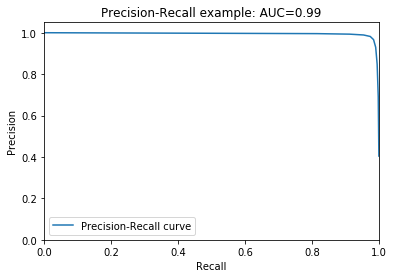

In [24]:
plt.plot(recall_, precision_, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example: AUC={0:0.2f}'.format(
    auc(recall_, precision_)))
plt.legend(loc="lower left")